In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.plot_utils import *

warnings.filterwarnings('ignore')

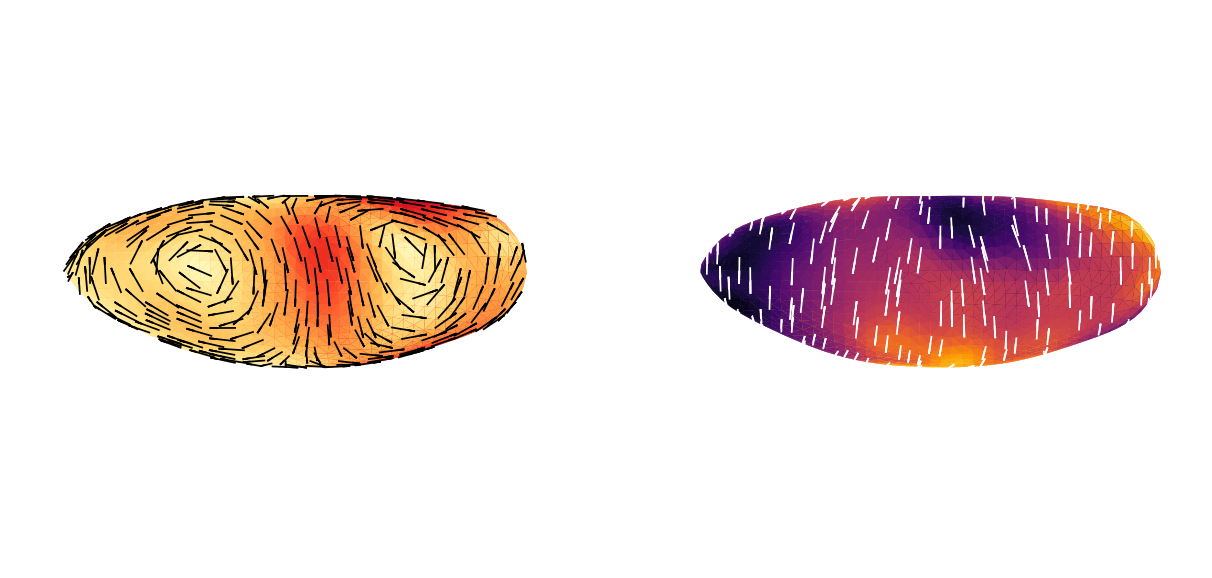

In [23]:
from scipy.io import loadmat
from utils.geometry.plot_utils import *

info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
v0 = info['u'].transpose(1,0)
m0 = info['myo'].transpose(1, 2, 0)

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))
plot_vector3D(ax[0], v0)
color_3D(ax[0], np.linalg.norm(v0, axis=0), cmap='YlOrRd')
plot_tensor3D(ax[1], m0)

## Build an incompressible Stokes in 2D

In [2]:
from utils.dataset import *

transform=Reshape2DField()

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True)
vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 6/6 [00:00<00:00, 594.64it/s]


### Finite differences method

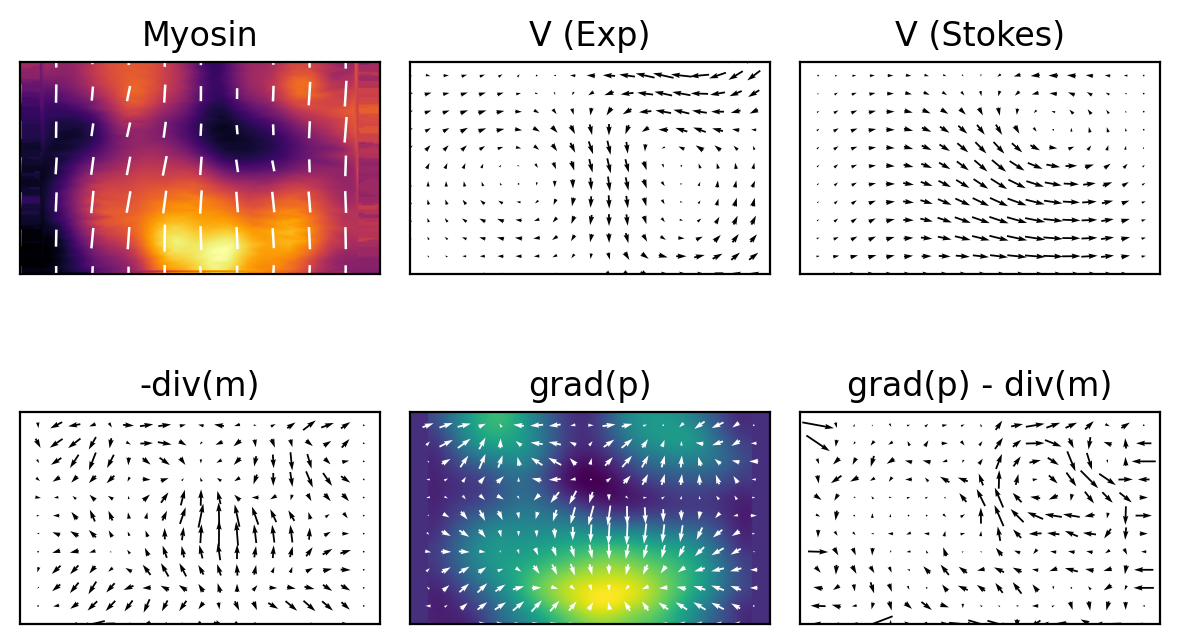

In [89]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.geometry.geometry_utils import *
from utils.forecasting.transforms import *
from utils.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, nDV=236, nAP=200, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = nDV
        self.nAP = nAP
        self.sigma = sigma
        self.mu = mu
        
        self.dAP = (ap_max - ap_min) / (nAP -1)
        self.dDV = (dv_max - dv_min) / (nDV -1)
        self.sigma = sigma
        
        self.Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D2_x = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D2_y = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D2_x = sparse.lil_matrix(D2_x)
        D2_x[0, [0, 1]] = [1, 0]
        D2_x[-1, [-2, -1]] = [0, 1]
        D2_x = sparse.csr_matrix(D2_x)
        
        #periodic BCs in DV direction
        D2_y = sparse.lil_matrix(D2_y)
        D2_y[0, [-1, 0, 1]] = [1, -2, 1]
        D2_y[-1, [-2, -1, 0]] = [1, -2, 1]
        D2_y = sparse.csr_matrix(D2_y)
        
        D2_x = sparse.kron(I_y, D2_x) / self.dAP**2
        D2_y = sparse.kron(D2_y, I_x) / self.dDV**2
        
        self.A = D2_x + D2_y
        self.mu = mu
        
        self.gradient = EmbryoGradient(sigma=self.sigma)
                
    def boundary_AP(self, f, ap=10):
        f[..., :ap] = 0
        f[..., -ap:] = 0
        return f
        
    def get_velocity(self, t, y):
        #Fit the gradient operator
        self.gradient.fit(y)
        
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])

        #Gradients
        div_m = np.einsum('ijyxj->iyx',self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
        
        # Mask poles
        #d2_m = self.boundary_AP(d2_m)
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        p = self.boundary_AP(p)
        div_m = self.boundary_AP(div_m)
        
        rhs = -div_m + d1_p
        rhs = self.boundary_AP(rhs) / self.mu
        
        v_y = sparse.linalg.spsolve(self.A, rhs[0].flatten())
        v_x = sparse.linalg.spsolve(self.A, rhs[1].flatten())
        
        v = np.stack([v_y, v_x]).reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m

from scipy.io import loadmat
info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
v0 = info['u'].transpose(1,0)
m0 = info['myo'].transpose(1, 2, 0)

interp  = MeshInterpolator().fit(None)
tangent = TangentSpaceTransformer().fit(None)

m0 = interp.inverse_transform(tangent.inverse_transform(m0))
v0 = interp.inverse_transform(tangent.inverse_transform(v0))

m0 = LeftRightSymmetrize().fit_transform(m0.reshape([1, 4, 236, 200]))

model = FlowSolver(mu=1)
v, p, div_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
plot_tensor2D(ax[0, 0], m0)
plot_vector2D(ax[0, 1], v0)
plot_vector2D(ax[1, 0], -div_m)
color_2D(ax[1, 1], p)
plot_vector2D(ax[0, 2], v)
plot_vector2D(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector2D(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

ax[1, 0].set_title('-div(m)')
ax[1, 1].set_title('grad(p)')
ax[1, 2].set_title('grad(p) - div(m)')

plt.tight_layout()

### Finite element method

Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file
Calling FFC just-in-time (JIT) compiler, this may take some time.
Plotting function
Plotting function


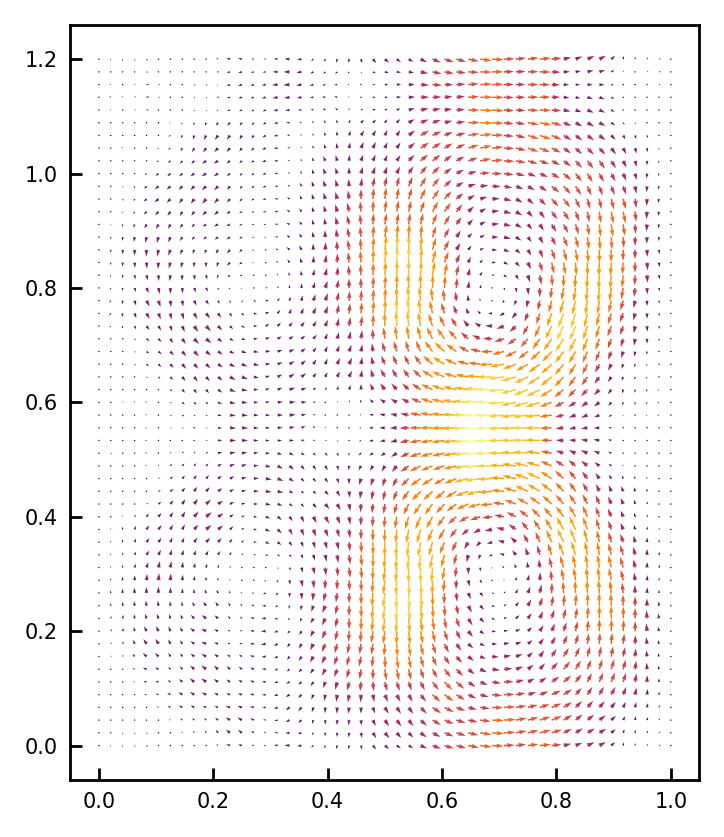

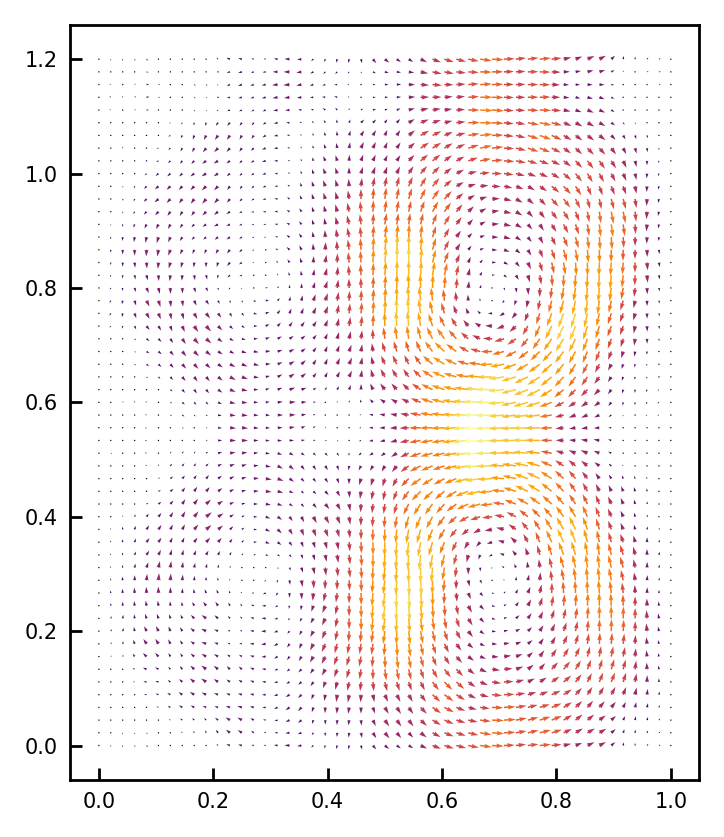

In [26]:
from scipy import sparse
from scipy.io import loadmat
from utils.geometry.fenics_utils import *
from utils.geometry.transforms import *
from utils.geometry.geometry_utils import *

plt.rcParams['figure.dpi'] = 250

info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
interp  = MeshInterpolator().fit(None)
tangent = TangentSpaceTransformer().fit(None)
gradient = FenicsGradient_v3(cutoff=0.1).fit(None)

v0 = tangent.inverse_transform(info['u'].transpose(1,0))
m0 = LeftRightSymmetrize().fit_transform(info['myo'].transpose(1, 2, 0))
m0 = tangent.inverse_transform(m0)
div_m = np.einsum('ijvj->iv', gradient.transform(m0))

m0 = interp.inverse_transform(m0)
div_m = interp.inverse_transform(div_m)
v0 = interp.inverse_transform(v0)

from fenics import RectangleMesh, Point, SubDomain, DOLFIN_EPS

mesh = RectangleMesh(Point(0., 0.), Point(1., 1.2), 48, 54)

class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[0] < (DOLFIN_EPS) or \
                     x[0] > (1. - DOLFIN_EPS)) and \
                    on_boundary)
    
    # Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Bottom boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[1] < (0 + DOLFIN_EPS) and \
                    x[1] > (0 - DOLFIN_EPS) and \
                    on_boundary)

    # Map top boundary (H) to bottom boundary (G)
    def map(self, x, y):
        y[0] = x[0]
        y[1] = x[1] - 1.2

from fenics import VectorElement, FiniteElement, FunctionSpace, Constant, DirichletBC
v1 = VectorElement('Lagrange', mesh.ufl_cell(), 1)
s1 = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
th = v1 * s1

W = FunctionSpace(mesh, th, constrained_domain=PeriodicBoundary())
V1 = FunctionSpace(mesh, v1)
bc = DirichletBC(W.sub(0), Constant((0., 0.)), DirichletBoundary())

from fenics import dof_to_vertex_map, Function, project
from scipy.interpolate import RectBivariateSpline
verts = mesh.coordinates()

dm_vs = np.zeros_like(verts)
dm_vs[:, 1] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[0])(verts[:, 1], verts[:, 0], grid=False)
dm_vs[:, 0] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[1])(verts[:, 1], verts[:, 0], grid=False)

d2v = dof_to_vertex_map(V1)
f = Function(V1)
f.vector().set_local(dm_vs.flatten()[d2v])
f = project(f, FunctionSpace(mesh, v1, constrained_domain=PeriodicBoundary()))

from fenics import TrialFunctions, TestFunctions, CellDiameter
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

#Stabilized formulation for first-order elements
beta = 0.2
h = CellDiameter(mesh)
delta = beta * h * h

from fenics import inner, grad, div, dx
a = inner(grad(u), grad(v)) * dx + div(v) * p * dx + q * div(u) * dx + delta * inner(grad(p), grad(q)) * dx
L = -inner(-f, v) * dx + delta * inner(-f, grad(q)) * dx

from fenics import assemble_system, plot

A, bb = assemble_system(a, L, [bc])

#Using Krylov subspace method and preconditioner
from fenics import KrylovSolver

b = inner(grad(u), grad(v)) * dx + p * q * dx
P, _  = assemble_system(b, L, [bc])

solver = KrylovSolver('minres', 'amg')
solver.set_operators(A, P)

U = Function(W)
solver.solve(U.vector(), bb)
v1, p = U.split()
plt.figure()
plot(v1)


#Assemble and solve directly without Krylov iterative solver
A = sparse.csr_matrix(np.asarray(A.array()))
L = sparse.csr_matrix(np.asarray(bb)).T

U = Function(W)
U.vector().set_local(sparse.linalg.spsolve(A, L))
v1, p = U.split()
plt.figure()
plot(v1)

Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file
Calling FFC just-in-time (JIT) compiler, this may take some time.
Plotting function
Plotting function


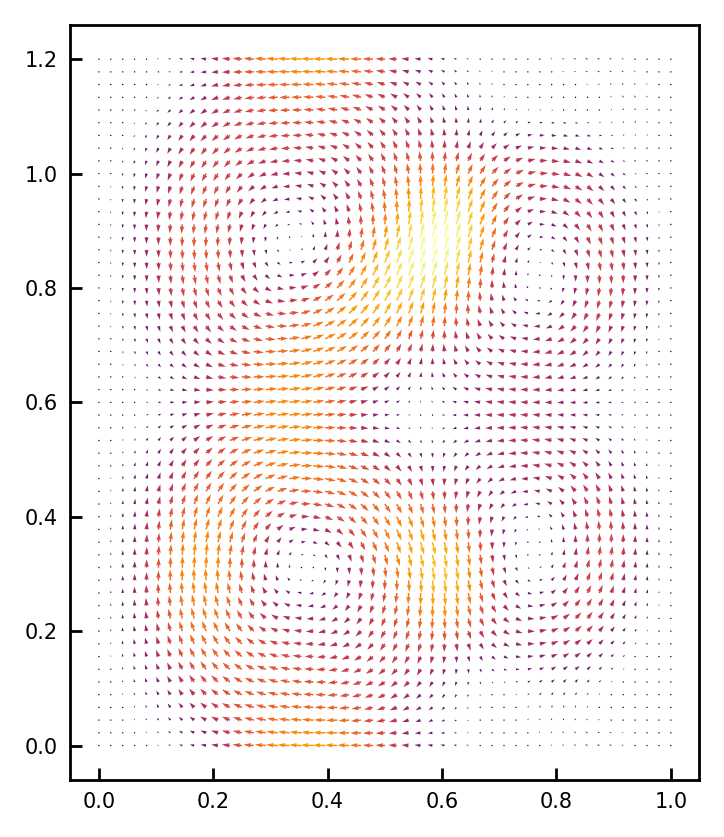

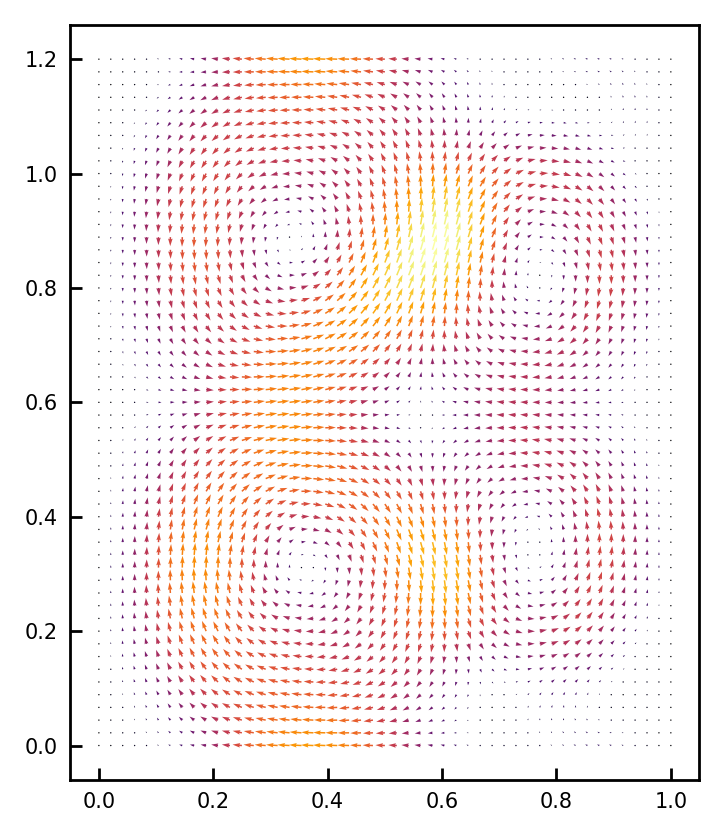

In [27]:
from scipy import sparse
from scipy.io import loadmat
from utils.geometry.fenics_utils import *
from utils.decomposition.decomposition_model import LeftRightSymmetrize

plt.rcParams['figure.dpi'] = 250

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = load_label_dataframe(path, drop_time=True)    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')

interp  = MeshInterpolator().fit(None)
tangent = TangentSpaceTransformer().fit(None)
gradient = FenicsGradient_v3(cutoff=0.1).fit(None)

ii = 23
v0 = v_full[ii]
m0 = LeftRightSymmetrize().fit_transform(m_full[ii].reshape([1, 4, 236, 200]))
div_m = np.einsum('ijvj->iv', gradient.transform(interp.transform(m0)))
div_m = interp.inverse_transform(div_m)

from fenics import VectorElement, FiniteElement, FunctionSpace, Constant, DirichletBC
v1 = VectorElement('Lagrange', mesh.ufl_cell(), 1)
s1 = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
th = v1 * s1

W = FunctionSpace(mesh, th, constrained_domain=PeriodicBoundary())
V1 = FunctionSpace(mesh, v1)
V2 = FunctionSpace(mesh, v1, constrained_domain=PeriodicBoundary())
bc = DirichletBC(W.sub(0), Constant((0., 0.)), DirichletBoundary())

from fenics import dof_to_vertex_map, Function, project
from scipy.interpolate import RectBivariateSpline
verts = mesh.coordinates()

dm_vs = np.zeros_like(verts)
dm_vs[:, 1] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[0])(verts[:, 1], verts[:, 0], grid=False)
dm_vs[:, 0] = RectBivariateSpline(
    np.linspace(0, 1.2, 236),
    np.linspace(0, 1, 200),
    div_m[1])(verts[:, 1], verts[:, 0], grid=False)

d2v = dof_to_vertex_map(V1)
f = Function(V1)
f.vector().set_local(dm_vs.flatten()[d2v])
f = project(f, V2)

from fenics import TrialFunctions, TestFunctions
u, p = TrialFunctions(W)
v, q = TestFunctions(W)

from fenics import inner, grad, div, dx
a = inner(grad(u), grad(v)) * dx + div(v) * p * dx + q * div(u) * dx
L = -inner(-f, v) * dx

from fenics import assemble_system
A, bb = assemble_system(a, L, [bc])

#Using Krylov subspace method and preconditioner
from fenics import KrylovSolver

b = inner(grad(u), grad(v)) * dx + p * q * dx
P, _  = assemble_system(b, L, [bc])

solver = KrylovSolver('minres', 'amg')
solver.set_operators(A, P)

U = Function(W)
solver.solve(U.vector(), bb)
v1, p = U.split()
plt.figure()
plot(v1)

#Assemble and solve directly without Krylov iterative solver
A = sparse.csr_matrix(np.asarray(A.array()))
L = sparse.csr_matrix(np.asarray(bb)).T

U = Function(W)
U.vector().set_local(sparse.linalg.spsolve(A, L))
v1, p = U.split()
plt.figure()
plot(v1)

## Build an incompressible Stokes model in 3D

Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file


Text(0.5, 1.0, 'V (fenics)')

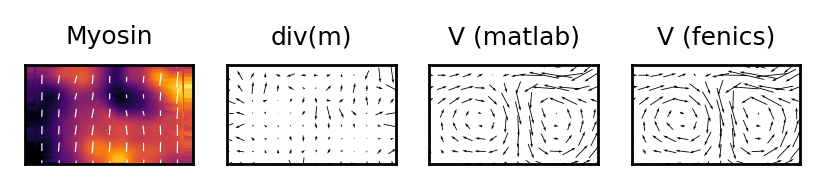

In [28]:
#Solve system exactly
from fenics import interpolate, project
from fenics import inner, grad, dot, div, dx
from fenics import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from fenics import FunctionSpace, VectorElement, TensorElement, MixedElement
from fenics import Mesh, Expression, Constant

from fenics import assemble_system, vertex_to_dof_map
from scipy import sparse
from scipy.sparse.linalg import spsolve

from utils.geometry.fenics_utils import *

plt.rcParams['font.size'] = 6

mesh_name = 'embryo_coarse_noll'

interp = MeshInterpolator(mesh_name).fit(None)
tangent = TangentSpaceTransformer(mesh_name).fit(None)
gradient = FenicsGradient_v2(mesh_name, cutoff=0.15).fit(None)

info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
v0 = info['u'].transpose(1,0)
m0 = info['myo'].transpose(1, 2, 0)

m0 = interp.inverse_transform(tangent.inverse_transform(m0))
v0 = interp.inverse_transform(tangent.inverse_transform(v0))

mesh = Mesh(os.path.join(geo_dir, f'{mesh_name}.xml'))
s = FiniteElement('CG', mesh.ufl_cell(), 1)
v = VectorElement('CG', mesh.ufl_cell(), 1)
S = FunctionSpace(mesh, s)
V = FunctionSpace(mesh, v)

W = FunctionSpace(mesh, v*s)
v2d = vertex_to_dof_map(W).reshape([-1, 4]).T.flatten()

u, p = TrialFunctions(W)
v, q = TestFunctions(W)

A = inner(grad(u), grad(v))*dx + div(v)*p*dx + q*div(u)*dx
C = -inner(u, v) * dx #For interpolating div(m) into space

A = build_operator(A, v2d)
C = build_operator(C, v2d)

def project(M, N):
    sep = N.shape[1]
    M11 = N @ M[:sep, :sep] @ N.T
    M12 = N @ M[:sep, sep:]
    M21 =     M[sep:, :sep] @ N.T
    M22 =     M[sep:, sep:]
    
    return sparse.csr_matrix(sparse.vstack([
        sparse.hstack([M11, M12]),
        sparse.hstack([M21, M22]),
    ]))

A = project(A, tangent.N[1])
C = project(C, tangent.N[1])

def solve_incompressible_stokes(m0):
    div_m = np.einsum('ijvj->iv', gradient.transform(interp.transform(m0)))
    sep = div_m.flatten().shape[0]
    L = C[:, :sep] @ -div_m.flatten()
    v1 = spsolve(A, L)[:sep]
    v1, div_m = interp.inverse_transform(v1), interp.inverse_transform(div_m)
    
    return v1, div_m

v1, div_m = solve_incompressible_stokes(m0)

fig, ax = plt.subplots(1, 4, dpi=250, figsize=(4, 1))

plot_tensor2D(ax[0], m0)
plot_vector2D(ax[1], div_m, skip=15)
plot_vector2D(ax[2], v0, skip=15, scale=3e2)
plot_vector2D(ax[3], v1, skip=15, scale=1e3)
ax[0].set_title('Myosin')
ax[1].set_title('div(m)')
ax[2].set_title('V (matlab)')
ax[3].set_title('V (fenics)')

Text(0.5, 1.0, 'V (stokes)')

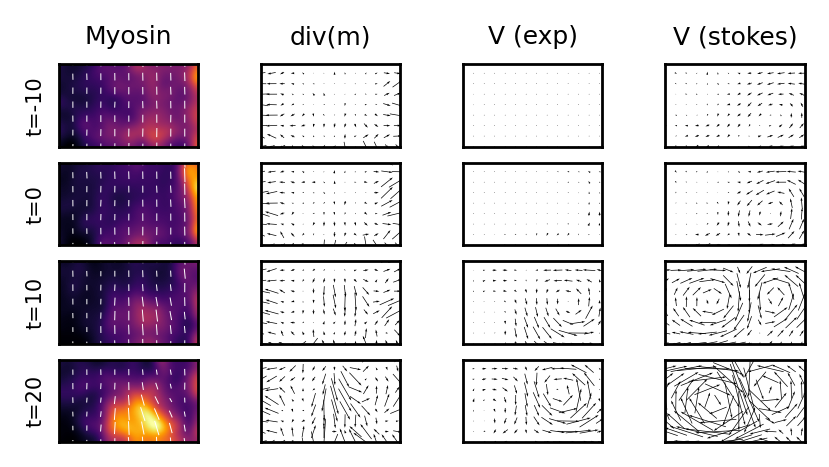

In [29]:
plt.rcParams['font.size'] = 6

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = load_label_dataframe(path, drop_time=True)    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'time'].values

fig, ax = plt.subplots(4, 4, dpi=250, figsize=(4, 2))
for i, t in enumerate([3, 13, 23, 33]):
    v0 = v_full[t]
    m0 = m_full[t].reshape([2, 2, 236, 200])
    time = t_full[t]

    v1, div_m = solve_incompressible_stokes(m0)

    plot_tensor2D(ax[i, 0], m0)
    plot_vector2D(ax[i, 1], div_m, skip=15, scale=1e-2)
    plot_vector2D(ax[i, 2], v0, skip=15, scale=5e1)
    plot_vector2D(ax[i, 3], v1, skip=15, scale=5e1)
    ax[i, 0].set_ylabel('t=%d' % time)
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('div(m)')
ax[0, 2].set_title('V (exp)')
ax[0, 3].set_title('V (stokes)')

## Build a compressible Stokes model in 3D

Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file


Text(0.5, 1.0, 'V (fenics)')

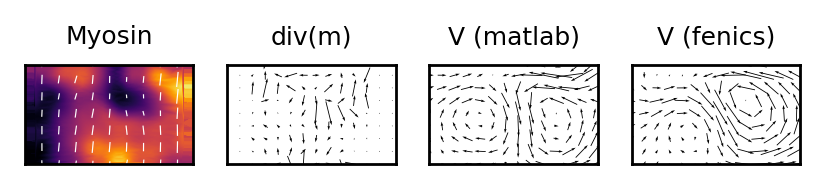

In [13]:
#Solve system exactly
from fenics import interpolate, project
from fenics import inner, grad, dot, div, dx
from fenics import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from fenics import FunctionSpace, VectorElement, TensorElement, MixedElement
from fenics import Mesh, Expression, Constant

from fenics import assemble_system, vertex_to_dof_map
from scipy import sparse
from scipy.sparse.linalg import spsolve

from utils.geometry.fenics_utils import *

plt.rcParams['font.size'] = 6

mesh_name = 'embryo_coarse_noll'

interp = MeshInterpolator(mesh_name).fit(None)
tangent = TangentSpaceTransformer(mesh_name).fit(None)
gradient = FenicsGradient_v3(mesh_name, cutoff=0.15).fit(None)

mesh = Mesh(os.path.join(geo_dir, f'{mesh_name}.xml'))
v = VectorElement('CG', mesh.ufl_cell(), 1)
t = TensorElement('CG', mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v)
T = FunctionSpace(mesh, t)
v2d_V = vertex_to_dof_map(V).reshape([-1, 3]).T.flatten()
v2d_T = vertex_to_dof_map(T).reshape([-1, 9]).T.flatten()

def solve_compressible_stokes(m0, time=0):
    eta = (1 + np.tanh(time-5)) * 50

    u = TrialFunction(V)
    v = TestFunction(V)
    A = -inner(grad(u), grad(v)) * dx(domain=mesh) + \
        -eta * div(u) * div(v) * dx(domain=mesh)
    B = inner(u, v) * dx(domain=mesh)

    A = build_operator(A, v2d_V)
    B = build_operator(B, v2d_V)
    
    A = tangent.N[1] @ A @ tangent.N[1].T
    B = tangent.N[1] @ B @ tangent.N[1].T
    
    
    div_m = np.einsum('ijvj->iv', gradient.transform(interp.transform(m0)))
    
    L = B.dot(-div_m.flatten())

    v1 = spsolve(A, L)
    
    return interp.inverse_transform(v1), interp.inverse_transform(div_m)

info = loadmat('/home/jcolen/fruit_fly/mesh_pinn/FEM_debugging.mat')
v0 = info['u'].transpose(1,0)
m0 = info['myo'].transpose(1, 2, 0)

m0 = interp.inverse_transform(tangent.inverse_transform(m0))
v0 = interp.inverse_transform(tangent.inverse_transform(v0))

fig, ax = plt.subplots(1, 4, dpi=250, figsize=(4, 1))

v1, div_m = solve_compressible_stokes(m0, 20)

plot_tensor2D(ax[0], m0)
plot_vector2D(ax[1], div_m, skip=15)
plot_vector2D(ax[2], v0, skip=15, scale=3e2)
plot_vector2D(ax[3], v1, skip=15, scale=1e3)
ax[0].set_title('Myosin')
ax[1].set_title('div(m)')
ax[2].set_title('V (matlab)')
ax[3].set_title('V (fenics)')

Text(0.5, 1.0, 'V (stokes)')

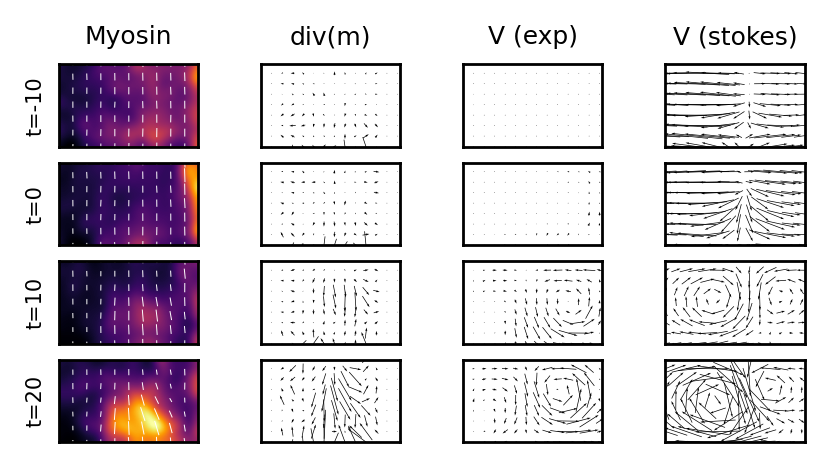

In [14]:
plt.rcParams['font.size'] = 6

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = load_label_dataframe(path, drop_time=True)    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'time'].values

fig, ax = plt.subplots(4, 4, dpi=250, figsize=(4, 2))
for i, t in enumerate([3, 13, 23, 33]):
    v0 = v_full[t]
    m0 = m_full[t].reshape([2, 2, 236, 200])
    time = t_full[t]

    v1, div_m = solve_compressible_stokes(m0, time)

    plot_tensor2D(ax[i, 0], m0)
    plot_vector2D(ax[i, 1], div_m, skip=15, scale=1e-2)
    plot_vector2D(ax[i, 2], v0, skip=15, scale=5e1)
    plot_vector2D(ax[i, 3], v1, skip=15, scale=5e1)
    ax[i, 0].set_ylabel('t=%d' % time)
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('div(m)')
ax[0, 2].set_title('V (exp)')
ax[0, 3].set_title('V (stokes)')